# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

In [2]:
pip show scikit-learn

Name: scikit-learn
Version: 0.24.1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /opt/anaconda3/lib/python3.8/site-packages
Requires: numpy, scipy, joblib, threadpoolctl
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [3]:
# make randomness predictable
np.random.seed(42)

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [4]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(f'Shape of demographics data: {azdias.shape}')
print(f'Shape of feature info data: {feat_info.shape}')

Shape of demographics data: (891221, 85)
Shape of feature info data: (85, 4)


In [6]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(feat_info)

                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GF

In [7]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [8]:
def cast_int(s):
    try:
        return int(s)
    except ValueError:
        return s

def get_unknown_values(col):
    unknown_values = []
    missing_or_unknown = feat_info[feat_info['attribute'] == col]['missing_or_unknown'].iloc[0]
    missing_or_unknown = missing_or_unknown.replace('[','')
    missing_or_unknown = missing_or_unknown.replace(']','')
    if len(missing_or_unknown) > 0:
        unknown_values = missing_or_unknown.split(',')
        unknown_values = [cast_int(u) for u in unknown_values]
    return unknown_values

In [9]:
# before applying migration: remember all the number of values of every columns that should be converted to NaNs
expected_nas = dict()
for col in azdias:
    unknown_values = get_unknown_values(col)
    sum_ = azdias[col].isna().sum()
    for unknown_value in unknown_values:
        sum_ += azdias[azdias[col] == unknown_value].shape[0]
    expected_nas[col] = sum_

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# Identify missing or unknown data values and convert them to NaNs.
for col in azdias:
    unknown_values = get_unknown_values(col)
    azdias[col] = azdias[col].apply(lambda v : np.nan if v in unknown_values else v)

In [11]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [12]:
# test if migration was successful
for col in azdias:
    sum_nans = azdias[col].isna().sum()
    if(sum_nans == expected_nas[col]):
        print(f'{col} ok.')
    else:
        print(f'{col} failed. {sum_nans} vs. {expected_nas[col]}')

AGER_TYP ok.
ALTERSKATEGORIE_GROB ok.
ANREDE_KZ ok.
CJT_GESAMTTYP ok.
FINANZ_MINIMALIST ok.
FINANZ_SPARER ok.
FINANZ_VORSORGER ok.
FINANZ_ANLEGER ok.
FINANZ_UNAUFFAELLIGER ok.
FINANZ_HAUSBAUER ok.
FINANZTYP ok.
GEBURTSJAHR ok.
GFK_URLAUBERTYP ok.
GREEN_AVANTGARDE ok.
HEALTH_TYP ok.
LP_LEBENSPHASE_FEIN ok.
LP_LEBENSPHASE_GROB ok.
LP_FAMILIE_FEIN ok.
LP_FAMILIE_GROB ok.
LP_STATUS_FEIN ok.
LP_STATUS_GROB ok.
NATIONALITAET_KZ ok.
PRAEGENDE_JUGENDJAHRE ok.
RETOURTYP_BK_S ok.
SEMIO_SOZ ok.
SEMIO_FAM ok.
SEMIO_REL ok.
SEMIO_MAT ok.
SEMIO_VERT ok.
SEMIO_LUST ok.
SEMIO_ERL ok.
SEMIO_KULT ok.
SEMIO_RAT ok.
SEMIO_KRIT ok.
SEMIO_DOM ok.
SEMIO_KAEM ok.
SEMIO_PFLICHT ok.
SEMIO_TRADV ok.
SHOPPER_TYP ok.
SOHO_KZ ok.
TITEL_KZ ok.
VERS_TYP ok.
ZABEOTYP ok.
ALTER_HH ok.
ANZ_PERSONEN ok.
ANZ_TITEL ok.
HH_EINKOMMEN_SCORE ok.
KK_KUNDENTYP ok.
W_KEIT_KIND_HH ok.
WOHNDAUER_2008 ok.
ANZ_HAUSHALTE_AKTIV ok.
ANZ_HH_TITEL ok.
GEBAEUDETYP ok.
KONSUMNAEHE ok.
MIN_GEBAEUDEJAHR ok.
OST_WEST_KZ ok.
WOHNLAGE ok.
CAMEO_

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
total_rows = azdias.shape[0]
for col in azdias:
    missing_ratio =  azdias[col].isna().sum() / total_rows
    if missing_ratio > 0.20:
        print(f'Missing ratio high for {col}: {missing_ratio}')

Missing ratio high for AGER_TYP: 0.7695543529607134
Missing ratio high for GEBURTSJAHR: 0.4402028228688507
Missing ratio high for TITEL_KZ: 0.9975763587258379
Missing ratio high for ALTER_HH: 0.34813699407890975
Missing ratio high for KK_KUNDENTYP: 0.6559674873011295
Missing ratio high for KBA05_BAUMAX: 0.5346866826522265


In [14]:
# Investigate patterns in the amount of missing data in each column.
# Column AGER_TYP Best-ager typology

# check if best_ager falls under a category in alterskategorie_grob
print(azdias['AGER_TYP'].value_counts(dropna=False))
print(azdias['ALTERSKATEGORIE_GROB'].value_counts(dropna=False))

NaN    685843
2.0     98472
1.0     79802
3.0     27104
Name: AGER_TYP, dtype: int64
3.0    358533
4.0    228510
2.0    158410
1.0    142887
NaN      2881
Name: ALTERSKATEGORIE_GROB, dtype: int64


NaN       392318
1967.0     11183
1965.0     11090
1966.0     10933
1970.0     10883
           ...  
1906.0         7
1904.0         5
1900.0         4
1907.0         4
1902.0         1
Name: GEBURTSJAHR, Length: 117, dtype: int64


<AxesSubplot:ylabel='Frequency'>

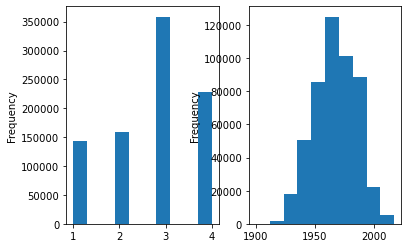

In [15]:
# Investigate patterns in the amount of missing data in each column.
# Column GEBURTSJAHR Year of birth
print(azdias['GEBURTSJAHR'].value_counts(dropna=False))

fig, (ax1, ax2) = plt.subplots(1, 2)
azdias['ALTERSKATEGORIE_GROB'].plot(kind='hist', ax=ax1)
azdias['GEBURTSJAHR'].plot(kind='hist', ax=ax2)

In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
drop_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KBA05_BAUMAX']
azdias = azdias.drop(columns=drop_columns)

for drop_column in drop_columns:
    index = feat_info[feat_info['attribute'] == drop_column].index
    feat_info = feat_info.drop(index) 

#### Discussion 1.1.2: Assess Missing Data in Each Column
In total there have been 6 columns where more than 20% of the data were missing. 

**AGER_TYP Best-ager typology 77% missing**
Best agers are considered people at around 50 years. In the dataset we have ~200k values. When we are looking at the column ALTERSKATEGORIE_GROB we see that in the dataset we do have ~360k people between 46yrs and 60yrs. If we consider this the catogisation for best agers still is only at around 55%. Although it could have a small effect on the clustering I would suggest to **drop** this column.

**GEBURTSJAHR Year of birth 44% missing**
The existing values form a nice Gaussian curve. Semantically there is a similar column ALTERSKATEGORIE_GROB, which also forms a similar curve. Therefore I deduct, that the ALTERSKATEGORIE_GROB contains valid values. I also think, that for this use case a categorization into a range of years is enough. Therefore I would suggest to **drop** this column.

**TITEL_KZ Academic title flag 99% missing**
A lot of missing data. Semantically the field ANZ_TITEL is similar. Therefore I would suggest to **drop** this column.

**ALTER_HH Birthdate of head of household 35% missing**
A lot of missing data. Semantically it should not affect the outcome of the model. Therefore I would suggest to **drop** this column.

**KK_KUNDENTYP Consumer pattern over past 12 months 66% missing**
Although a lot of data is missing, this column is very interesting for our use case. Therefore I would suggest to **keep** this column. The handling of the missing values has to be defined afterwards.

**KBA05_BAUMAX Most common building type within the microcell 53% missing**
Can be derived from the columns KBA05_ANTG1 - KBA05_ANTG5, where less values are missing. Therefore I would suggest to **drop** this column. 





#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [17]:
# How much data is missing in each row of the dataset?
missing = azdias.isna().sum(axis=1)
missing.describe()


count    891221.000000
mean          6.305861
std          13.337837
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          50.000000
dtype: float64

In [18]:
missing[missing <= 20].count() / missing.count()

0.8944795959700231

In [19]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 20 # we split the dataset to get approx a 90-10 split (good-bad)
data = azdias[azdias.isna().sum(axis=1) <= threshold]
data_high_missing = azdias[azdias.isna().sum(axis=1) > threshold]
print(f'Shape of data missing <= {threshold}: {data.shape}')
print(f'Shape of data missing > {threshold}: {data_high_missing.shape}')

Shape of data missing <= 20: (797179, 80)
Shape of data missing > 20: (94042, 80)


In [20]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
cols = (data.isna().sum() <= threshold)&(data_high_missing.isna().sum() <= threshold)
cols = cols[cols == True].index.to_list()
cols

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP']

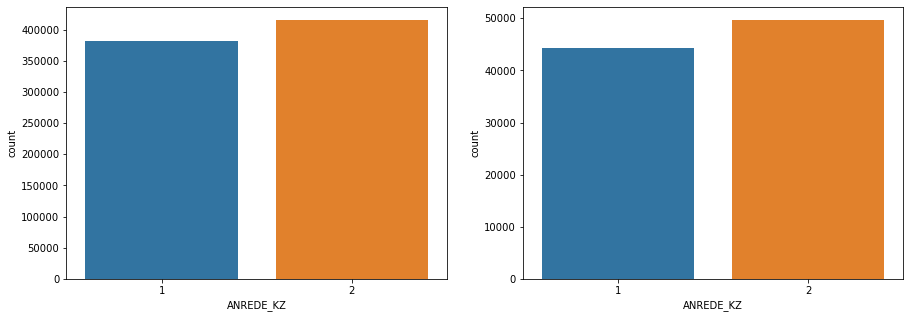

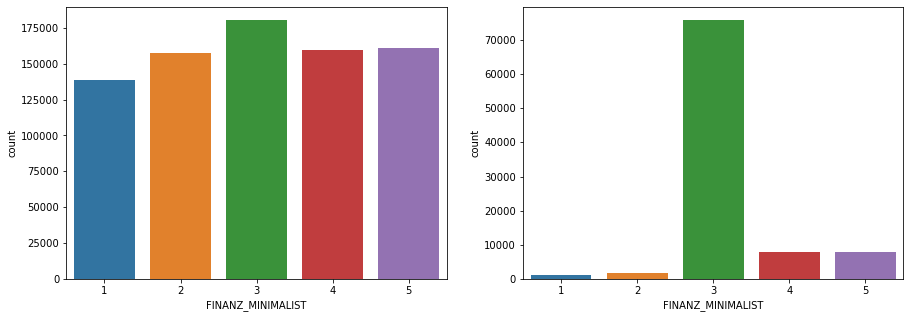

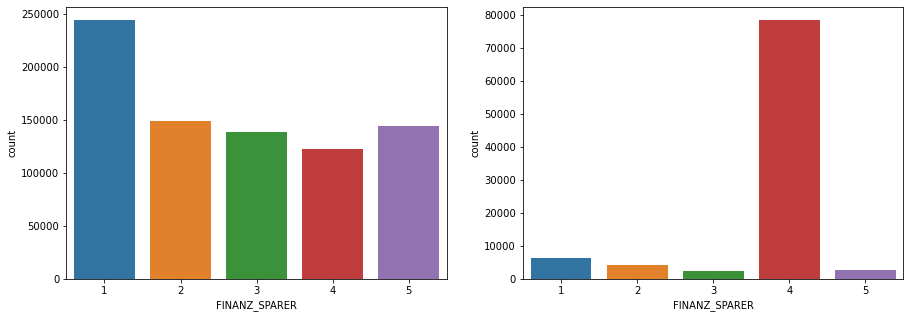

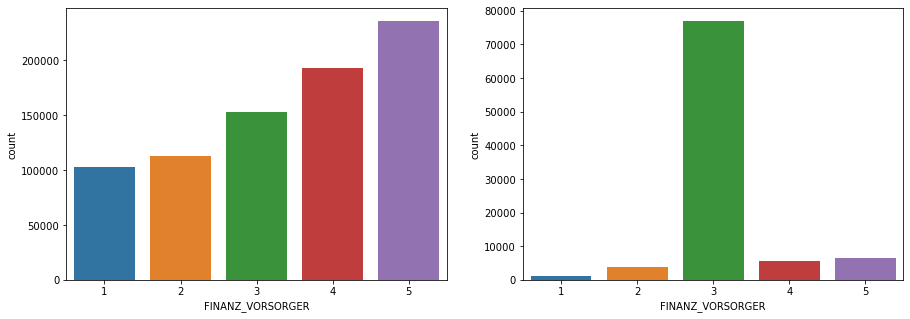

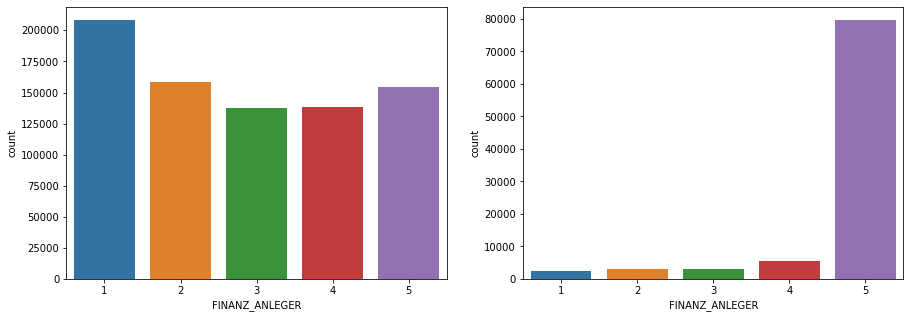

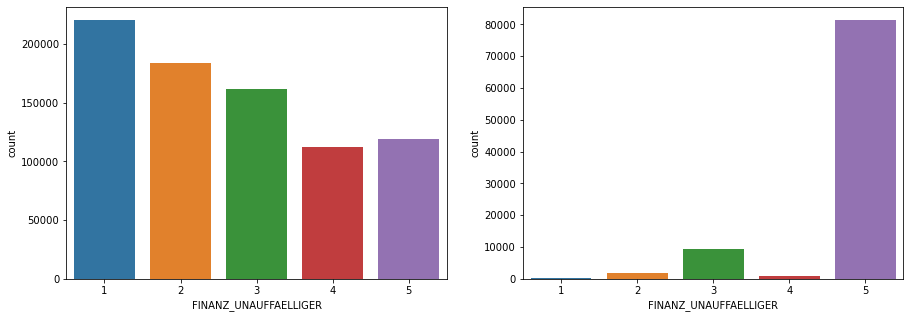

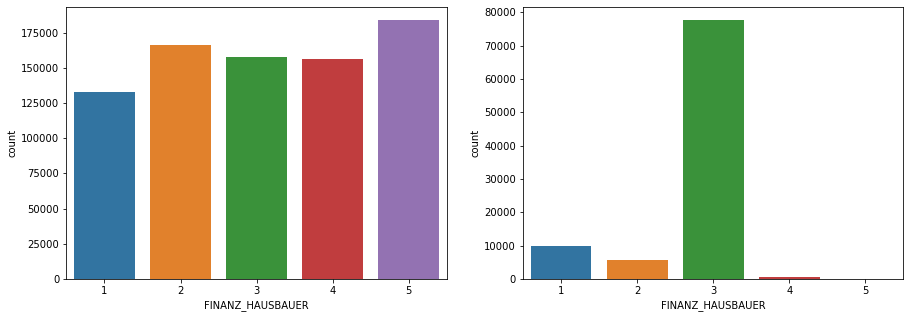

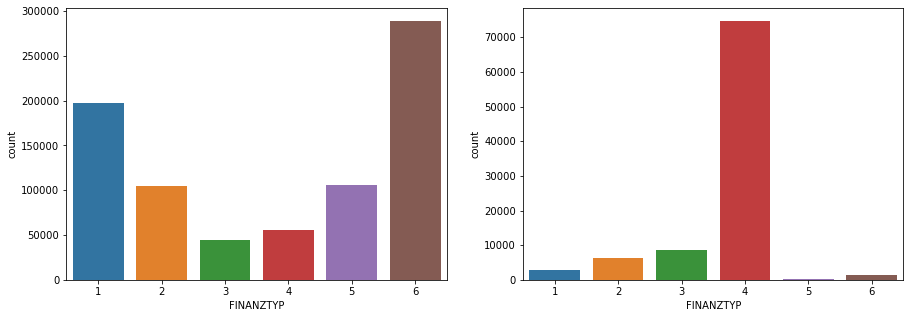

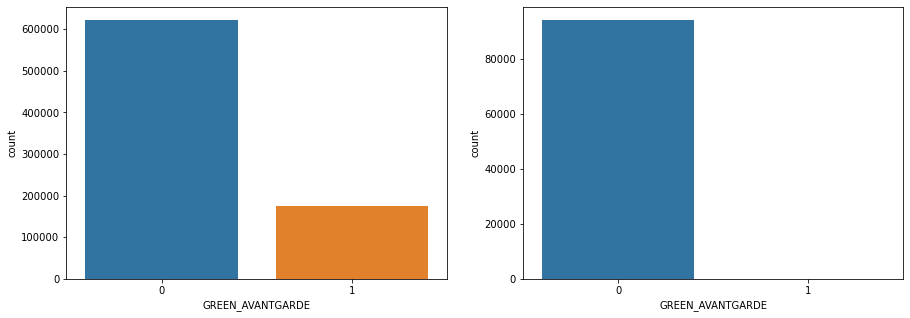

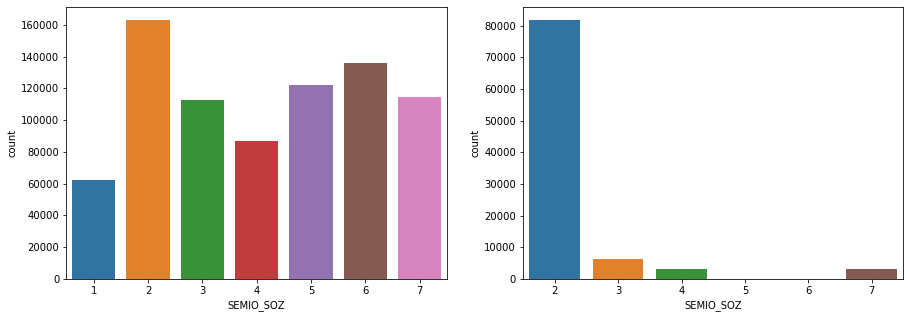

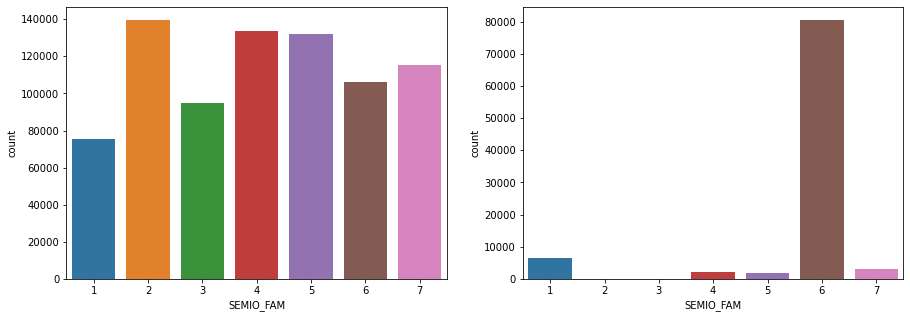

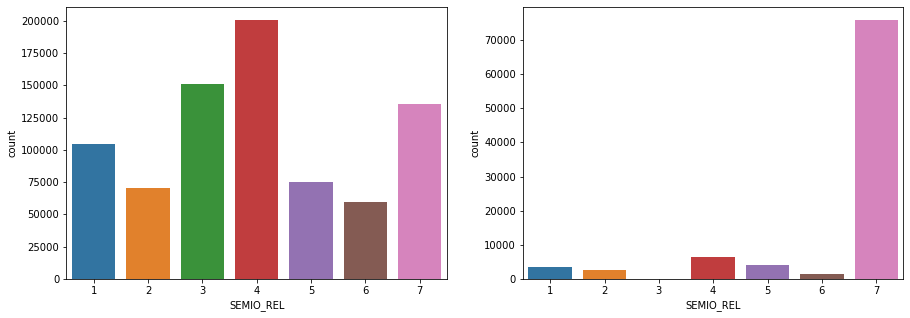

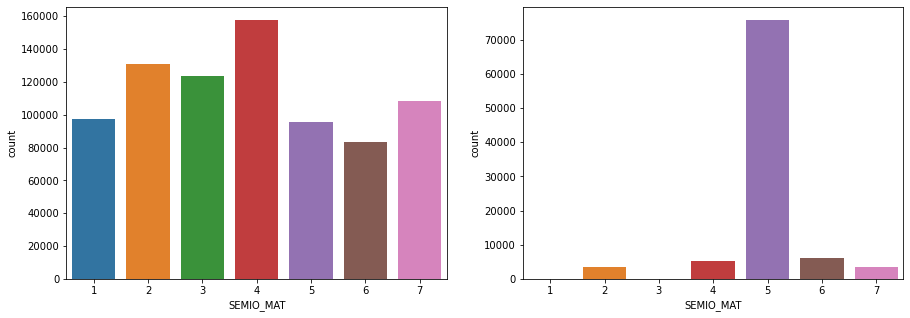

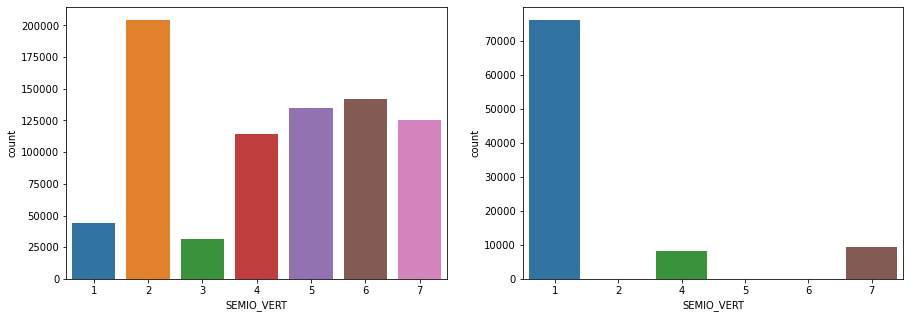

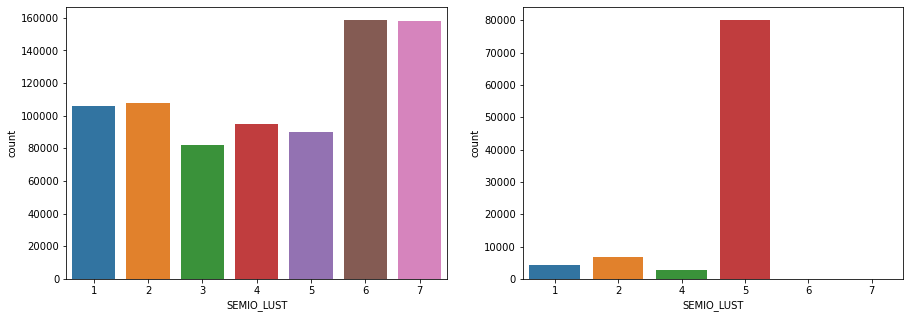

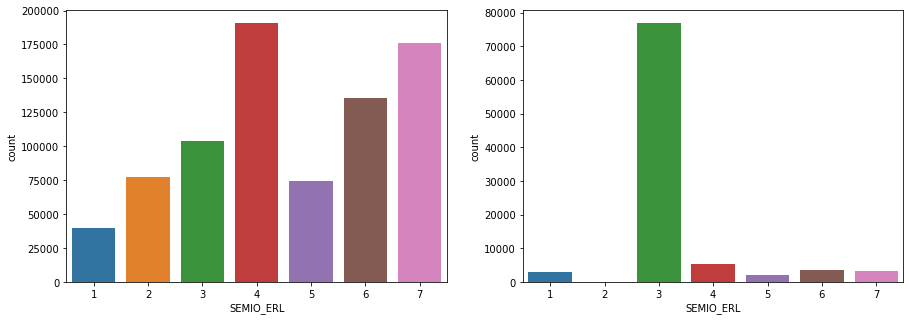

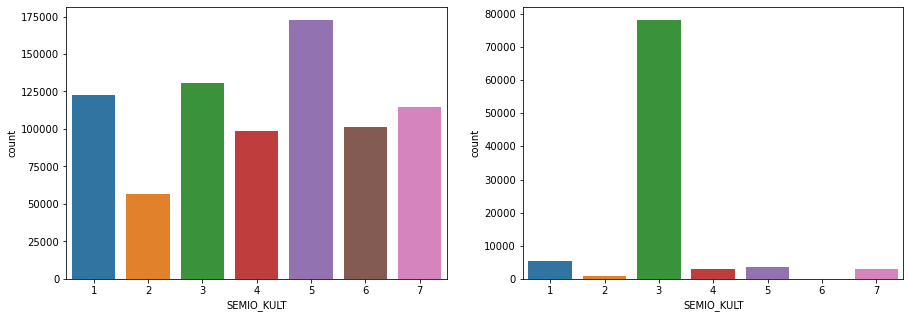

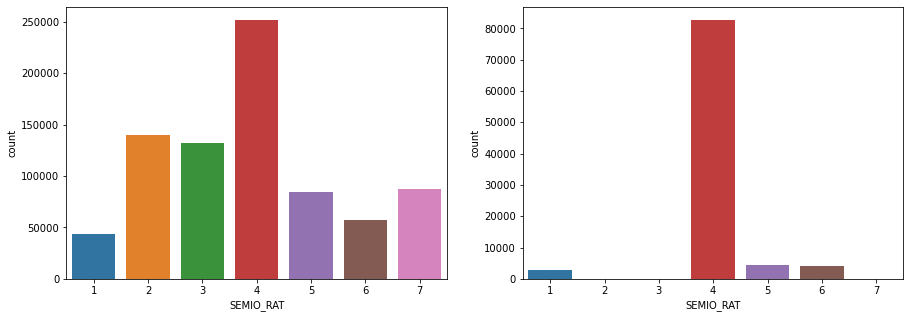

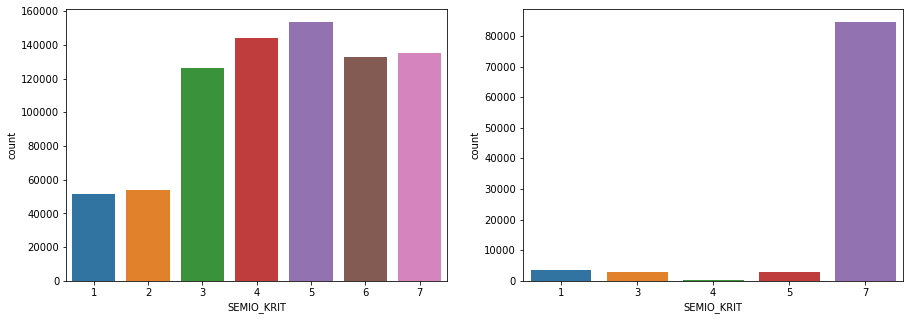

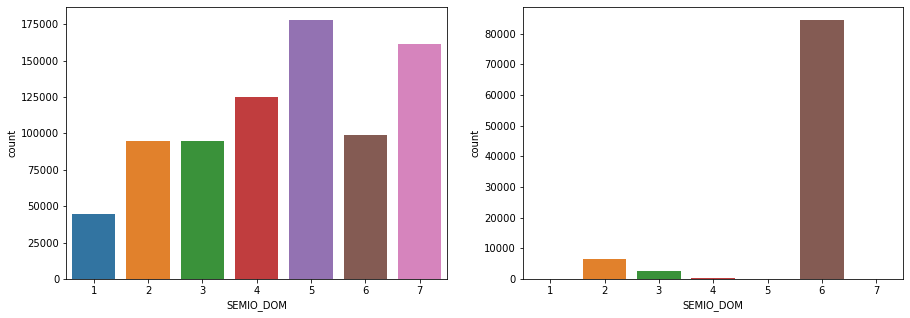

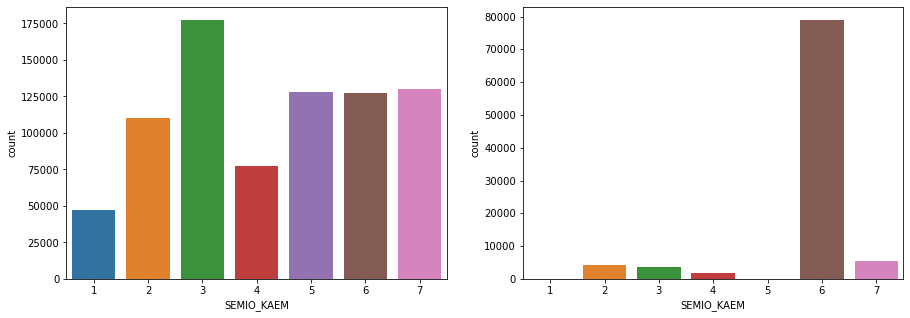

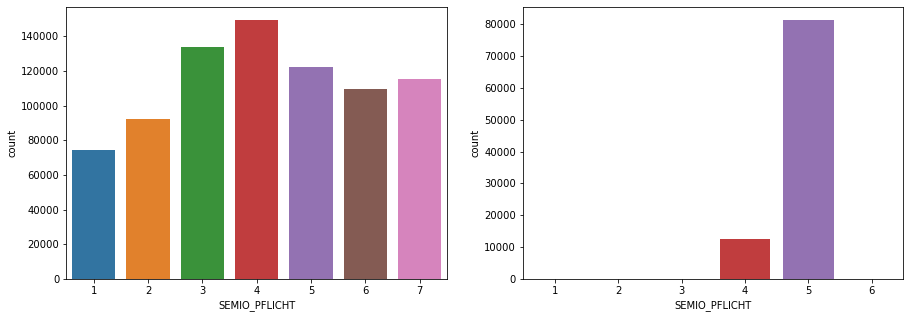

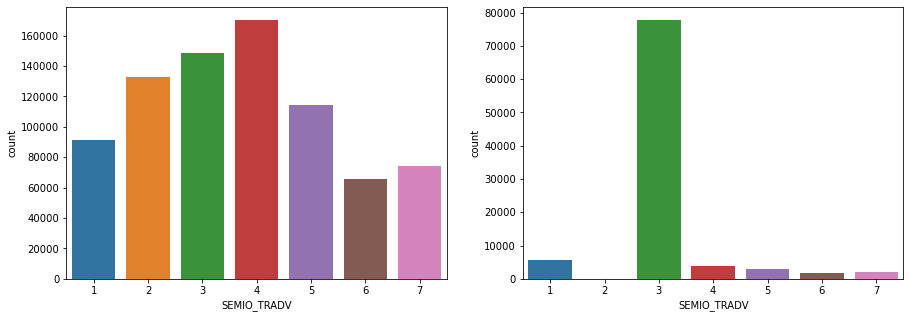

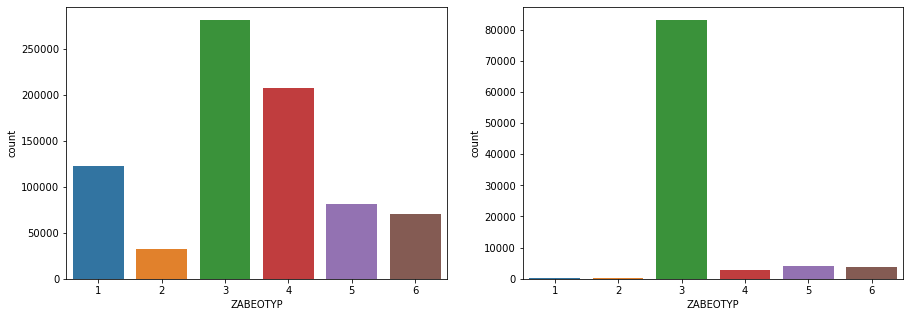

In [21]:
def compare_distribution(colname):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
    sns.countplot(x=colname,data=data, ax=axes[0])
    sns.countplot(x=colname, data=data_high_missing, ax=axes[1])
    plt.show()

for col in cols:
    compare_distribution(col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

For the most columns the distribution between the two datasets is different (i.e. for FINANZ_SPARER, FINANZ_ANLEGER, SEMIO_FAM). So we should mark the data as special.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [22]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    19
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.

- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [23]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
hot_encode = list()
for _, row in feat_info[feat_info['type'] == 'categorical'].iterrows():
    col = row['attribute']
    unique_values = data[col].dropna().unique()
    print(f"Unique values for {col}: {unique_values}")
    if data[col].dtype == object:
        hot_encode.append(col) 
    elif len(unique_values) > 2:
        hot_encode.append(col)

hot_encode


Unique values for ANREDE_KZ: [2 1]
Unique values for CJT_GESAMTTYP: [5. 3. 2. 4. 1. 6.]
Unique values for FINANZTYP: [1 6 5 2 4 3]
Unique values for GFK_URLAUBERTYP: [10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6.]
Unique values for GREEN_AVANTGARDE: [0 1]
Unique values for LP_FAMILIE_FEIN: [ 5.  1. 10.  2.  7. 11.  8.  4.  6.  9.  3.]
Unique values for LP_FAMILIE_GROB: [3. 1. 5. 2. 4.]
Unique values for LP_STATUS_FEIN: [ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7.]
Unique values for LP_STATUS_GROB: [1. 2. 4. 5. 3.]
Unique values for NATIONALITAET_KZ: [1. 3. 2.]
Unique values for SHOPPER_TYP: [3. 2. 1. 0.]
Unique values for SOHO_KZ: [1. 0.]
Unique values for VERS_TYP: [2. 1.]
Unique values for ZABEOTYP: [5 3 4 1 6 2]
Unique values for KK_KUNDENTYP: [1. 3. 6. 4. 2. 5.]
Unique values for GEBAEUDETYP: [8. 1. 3. 2. 6. 4. 5.]
Unique values for OST_WEST_KZ: ['W' 'O']
Unique values for CAMEO_DEUG_2015: ['8' '4' '2' '6' '1' '9' '5' '7' '3']
Unique values for CAMEO_DEU_2015: ['8A' '4C' '2A' '6B' '8

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [24]:
# Re-encode categorical variable(s) to be kept in the analysis.
data = pd.get_dummies(data=data, prefix_sep='__', columns=hot_encode)
data.columns.to_list()

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'VERS_TYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PL

#### Discussion 1.2.1: Re-Encode Categorical Features

I decided to hot encode all the categorical columns as described (columns with strings or more than 2 unique values in a column). I was thinking to hot encode the categorical columns with only 2 distinct numeric values too (ANREDE_KZ, SOHO_KZ, VERS_TYP), but I then decided to not do that, because: it would increase the numbers of columns even more and I think this can be handled by a good scaling afterwards.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [25]:
feat_info[feat_info['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [26]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
decade_map = {
    1:40, 2:40,
    3:50, 4:50,
    5:60, 6:60, 7:60,
    8:70, 9:70,
    10:80, 11:80, 12:80, 13:80,
    14:90, 15:90
}

movement_map = {
    1:0, 3:0, 5:0, 8:0, 10:0, 12:0, 14:0,
    2:1, 4:1, 6:1, 7:1, 9:1, 11:1, 13:1, 15:1
}

data.loc[:,'PRAEGENDE_JUGENDJAHRE_decade'] = data.apply(lambda row : decade_map.get(row['PRAEGENDE_JUGENDJAHRE'], np.nan), axis=1)
data.loc[:,'PRAEGENDE_JUGENDJAHRE_movement'] = data.apply(lambda row : movement_map.get(row['PRAEGENDE_JUGENDJAHRE'], np.nan), axis=1)
data.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [27]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def split_c_i_2015(row):
    value = row['CAMEO_INTL_2015']
    if pd.isna(value):
        return np.nan, np.nan
    elif len(value) != 2:
        return np.nan, np.nan
    elif not value.isdigit():
        return np.nan, np.nan
    else:
        return int(value[0]), int(value[1])

def get_wealth_status(row):
    return split_c_i_2015(row)[0]

def get_life_status(row):
    return split_c_i_2015(row)[1]

data.loc[:,'CAMEO_INTL_2015_wealth'] = data.apply(get_wealth_status, axis=1)
data.loc[:,'CAMEO_INTL_2015_life'] = data.apply(get_life_status, axis=1)
data.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [28]:
data.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'], axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

I decided to transform the columns as described: Therefore I splitted the two columns PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 into 2 new columns each. Due to the already large amount of existing columns and the semantiv overlap with existing columns I decided to delete the other 4 columns of type mixed and to not reengineer them (this might be an option for a later optimization or double check)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [29]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
data = data[sorted(data.columns)]

In [30]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
for col in data:
    print(f"{col}: {data[col].dtype}")


ALTERSKATEGORIE_GROB: float64
ANREDE_KZ: int64
ANZ_HAUSHALTE_AKTIV: float64
ANZ_HH_TITEL: float64
ANZ_PERSONEN: float64
ANZ_TITEL: float64
ARBEIT: float64
BALLRAUM: float64
CAMEO_DEUG_2015__1: uint8
CAMEO_DEUG_2015__2: uint8
CAMEO_DEUG_2015__3: uint8
CAMEO_DEUG_2015__4: uint8
CAMEO_DEUG_2015__5: uint8
CAMEO_DEUG_2015__6: uint8
CAMEO_DEUG_2015__7: uint8
CAMEO_DEUG_2015__8: uint8
CAMEO_DEUG_2015__9: uint8
CAMEO_DEU_2015__1A: uint8
CAMEO_DEU_2015__1B: uint8
CAMEO_DEU_2015__1C: uint8
CAMEO_DEU_2015__1D: uint8
CAMEO_DEU_2015__1E: uint8
CAMEO_DEU_2015__2A: uint8
CAMEO_DEU_2015__2B: uint8
CAMEO_DEU_2015__2C: uint8
CAMEO_DEU_2015__2D: uint8
CAMEO_DEU_2015__3A: uint8
CAMEO_DEU_2015__3B: uint8
CAMEO_DEU_2015__3C: uint8
CAMEO_DEU_2015__3D: uint8
CAMEO_DEU_2015__4A: uint8
CAMEO_DEU_2015__4B: uint8
CAMEO_DEU_2015__4C: uint8
CAMEO_DEU_2015__4D: uint8
CAMEO_DEU_2015__4E: uint8
CAMEO_DEU_2015__5A: uint8
CAMEO_DEU_2015__5B: uint8
CAMEO_DEU_2015__5C: uint8
CAMEO_DEU_2015__5D: uint8
CAMEO_DEU_2015__5E: u

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [31]:
# helper function that tries to cast to an int
def try_int(s):
    try:
        return int(s)
    except ValueError:
        return s

# Helper function to get unknown values by a column name
def get_unknown_values(col, df_info):
    unknown_values = []
    missing_or_unknown = df_info[df_info['attribute'] == col]['missing_or_unknown'].iloc[0]
    missing_or_unknown = missing_or_unknown.replace('[','')
    missing_or_unknown = missing_or_unknown.replace(']','')
    if len(missing_or_unknown) > 0:
        unknown_values = missing_or_unknown.split(',')
        unknown_values = [try_int(u) for u in unknown_values]
    return unknown_values

# Helper function to get features that has to be hot encoded
def get_hot_endoce(df, df_info):
    hot_encode = list()
    for _, row in df_info[df_info['type'] == 'categorical'].iterrows():
        col = row['attribute']
        if col in df:
            unique_values = df[col].dropna().unique()
            if df[col].dtype == object:
                hot_encode.append(col) 
            elif len(unique_values) > 2:
                hot_encode.append(col)
    return hot_encode

def clean_data(df, df_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for col in df:
        unknown_values = get_unknown_values(col, df_info)
        df[col] = df[col].apply(lambda v : np.nan if v in unknown_values else v)
    
    # remove selected columns and rows, ...
    df.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KBA05_BAUMAX'], axis=1, inplace=True)
    df = df[df.isna().sum(axis=1) <= 1]
    
    # select, re-encode, and engineer column values.
    hot_encode = get_hot_endoce(df, df_info)
    df = pd.get_dummies(data=df, prefix_sep='__', columns=hot_encode)
    
    df.loc[:,'PRAEGENDE_JUGENDJAHRE_decade'] = df.apply(lambda row : decade_map.get(row['PRAEGENDE_JUGENDJAHRE'], np.nan), axis=1)
    df.loc[:,'PRAEGENDE_JUGENDJAHRE_movement'] = df.apply(lambda row : movement_map.get(row['PRAEGENDE_JUGENDJAHRE'], np.nan), axis=1)
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    df.loc[:,'CAMEO_INTL_2015_wealth'] = df.apply(get_wealth_status, axis=1)
    df.loc[:,'CAMEO_INTL_2015_life'] = df.apply(get_life_status, axis=1)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    df.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'], axis=1, inplace=True)
    
    #Add a missing column that is created during hot encoding, but a value is missing in this subset
    if 'GEBAEUDETYP__5.0' not in df:
        df['GEBAEUDETYP__5.0'] = 0
    
    df = df[sorted(df.columns)]
    # Return the cleaned dataframe.
    return df
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [32]:
features = data.copy()

In [33]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
features = imputer.fit_transform(features)

In [34]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

### Discussion 2.1: Apply Feature Scaling

I replaced the missing values with the median of the values from the column. I choose this strategy over the mean, because it is more robust when there are some outliers. The features are then scaled using the StandardScaler.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [35]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(features)


PCA()

In [36]:
# taken from https://github.com/ksatola/Udacity-Data-Scientist-Nanodegree-Unsupervised-Learning/blob/master/04-Dimensionality-Reduction-and-PCA/helper_functions.py
# adjusted some representation config
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:2])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

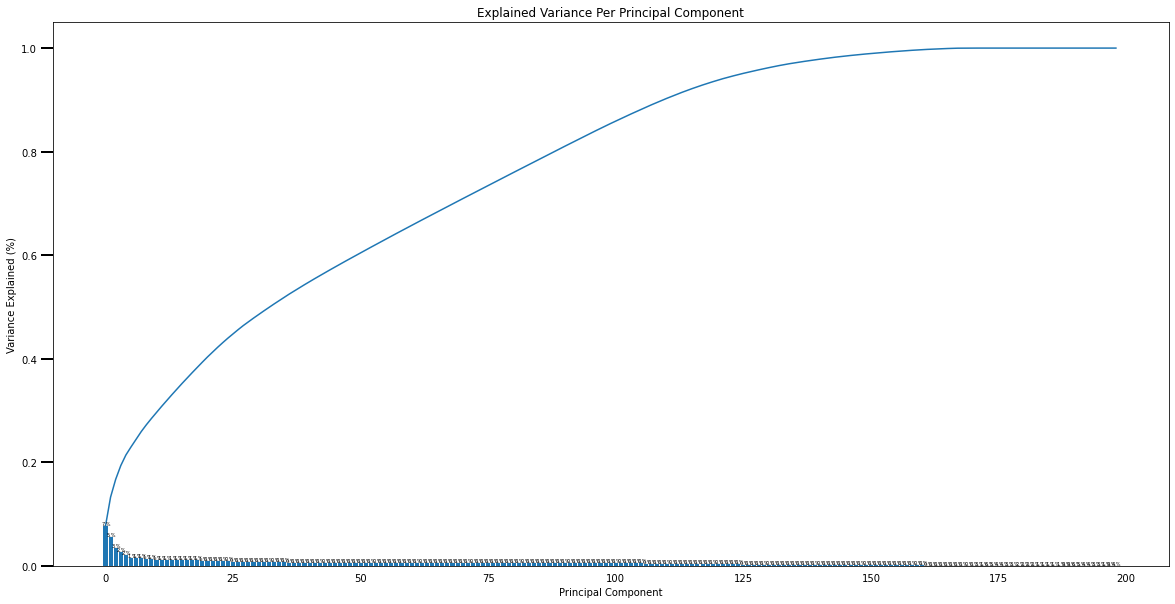

In [37]:
scree_plot(pca)

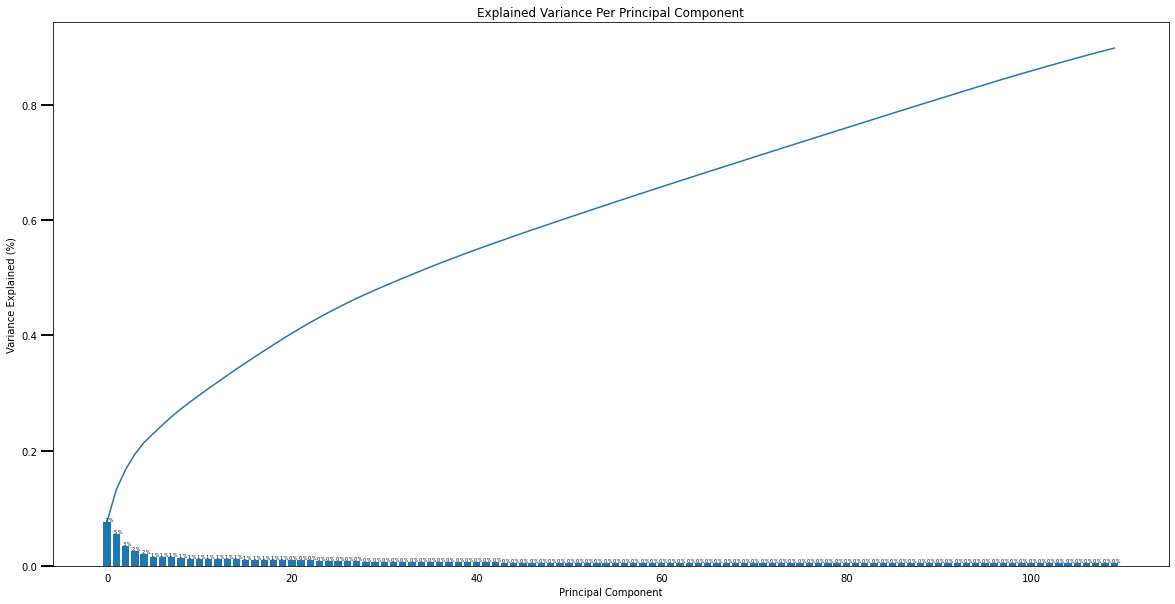

In [38]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_110 = PCA(110)
features = pca_110.fit_transform(features)
scree_plot(pca_110)


### Discussion 2.2: Perform Dimensionality Reduction

After investigating the variance per principal component, I decided to use 110 principal components. The initial components are almost halved, while keeping around 90% of the variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [39]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def print_pca_weights(pca, data, component):
    df = pd.DataFrame(pca.components_, columns=data.columns.to_list())
    weights = df.iloc[component].sort_values(ascending=False)
    print(weights)

print_pca_weights(pca_110, data, 0)

LP_STATUS_GROB__1.0       0.196356
HH_EINKOMMEN_SCORE        0.186950
CAMEO_INTL_2015_wealth    0.186429
PLZ8_ANTG3                0.181724
PLZ8_ANTG4                0.175980
                            ...   
KBA05_GBZ                -0.181315
PLZ8_ANTG1               -0.183125
KBA05_ANTG1              -0.189433
FINANZ_MINIMALIST        -0.191033
MOBI_REGIO               -0.205440
Name: 0, Length: 199, dtype: float64


In [40]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_pca_weights(pca_110, data, 1)

ALTERSKATEGORIE_GROB            0.233505
FINANZ_VORSORGER                0.219008
ZABEOTYP__3                     0.200969
SEMIO_ERL                       0.180037
SEMIO_LUST                      0.164127
                                  ...   
SEMIO_TRADV                    -0.208290
SEMIO_REL                      -0.213704
FINANZ_UNAUFFAELLIGER          -0.215742
FINANZ_SPARER                  -0.227458
PRAEGENDE_JUGENDJAHRE_decade   -0.238879
Name: 1, Length: 199, dtype: float64


In [41]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_pca_weights(pca_110, data, 2)


SEMIO_VERT      0.319015
SEMIO_FAM       0.260955
SEMIO_SOZ       0.257122
SEMIO_KULT      0.251934
FINANZTYP__5    0.134701
                  ...   
SEMIO_ERL      -0.208410
SEMIO_KRIT     -0.266996
SEMIO_DOM      -0.284093
SEMIO_KAEM     -0.315604
ANREDE_KZ      -0.345262
Name: 2, Length: 199, dtype: float64


### Discussion 2.3: Interpret Principal Components

It is obvious that the first component is affected a lot by the financial situation of an individual and its household (LP_STATUS_GROB, HH_EINKOMMEN_SCORE, CAMEO_INTL_2015). The component is also affected positively if the individual lives in a cell with a lot of family houses (what indirectly is also reflecting its financial situation). On the other hand it is interesting to see, that the component is affected negatively by how the individual is spending his money (FINANZ_MINIMALIST)

The second component is affected by the personality of an individual (SEMIO_xyz), positvely and negatively. And again, financial properties and the age. In this component we have several features that we marked as special because the distribution differs from within the datasets. The good thing is though, that the features that affects the component most (positively and negatively) are not marked as special.

The third component is then affected heavily (in both directions, positive and negatively) by the personality. Here we have to be careful, because the semio features has been marked as special (see above), because their distribution was different in the cleaned dataset and the dataset with a lot of null values. For a later step, it would be recommended to double check this.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [42]:
len_slice = int(features.shape[0]*0.2)
indexes = np.random.choice(features.shape[0], size=len_slice, replace=False)
features_slice = features[indexes]

In [43]:
from sklearn.cluster import KMeans

# Over a number of different cluster counts...
scores = list()
clusters = list(range(3,31))
for k in clusters:
    kmeans_k = KMeans(n_clusters=k)
    model_k = kmeans_k.fit(features_slice)
    score = np.abs(model_k.score(features_slice))
    scores.append(score)
    print(f"Score for {k} clusters: {score}")

Score for 3 clusters: 25572093.319153775
Score for 4 clusters: 24972152.548203085
Score for 5 clusters: 24499280.19209721
Score for 6 clusters: 24206372.2762889
Score for 7 clusters: 23948288.85389794
Score for 8 clusters: 23711087.950774428
Score for 9 clusters: 23516539.870682463
Score for 10 clusters: 23256383.932054393
Score for 11 clusters: 23076651.757809967
Score for 12 clusters: 22958148.26374499
Score for 13 clusters: 22750771.845731482
Score for 14 clusters: 22718870.698734485
Score for 15 clusters: 22525112.403440487
Score for 16 clusters: 22359721.886018038
Score for 17 clusters: 22196335.636615057
Score for 18 clusters: 22095472.87684931
Score for 19 clusters: 21945917.463899896
Score for 20 clusters: 21814763.509966735
Score for 21 clusters: 21768402.294186465
Score for 22 clusters: 21650626.44051673
Score for 23 clusters: 21512137.5746403
Score for 24 clusters: 21319067.909693044
Score for 25 clusters: 21278680.76167826
Score for 26 clusters: 21214112.944250427
Score for

Text(0, 0.5, 'score')

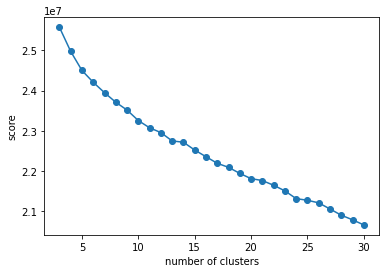

In [44]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(clusters, scores, linestyle='-', marker='o')
plt.xlabel('number of clusters')
plt.ylabel('score')

In [45]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=19)
model = kmeans.fit(features)
general_prediction = model.predict(features)

### Discussion 3.1: Apply Clustering to General Population

From the figure an elbow is not clearly visible. There is almost a constant drop of the score. To not have to many clusters I choose to go for 19 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [46]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

# Reload Feat_info (was changed before)
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [47]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned = clean_data(customers, feat_info)
customers_imputer = imputer.transform(customers_cleaned)
customers_normalize = scaler.transform(customers_imputer)
customers_features = pca_110.transform(customers_normalize)
customer_pred = model.predict(customers_features)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

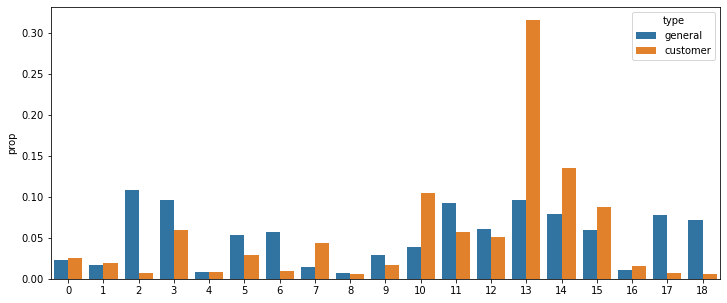

In [48]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
# general_prediction customer_pred

general_prop = pd.Series(general_prediction).value_counts(normalize=True, ascending=True, sort=False)
general_data = {
    'prop': general_prop,
    'type': 'general'
}
general_df = pd.DataFrame(general_data)

customer_prop = pd.Series(customer_pred).value_counts(normalize=True, ascending=True, sort=False)
customer_data = {
    'prop': customer_prop,
    'type': 'customer'
}
customer_df = pd.DataFrame(customer_data)
overall_df = pd.concat([general_df, customer_df])

fig, ax = plt.subplots(figsize=(12,5))
ax = sns.barplot(x=overall_df.index, y="prop", hue="type", data=overall_df)

In [64]:
prop_diff = general_prop - customer_prop
prop_diff.sort_values()

13   -0.219738
10   -0.066210
14   -0.056151
7    -0.028600
15   -0.027160
16   -0.004826
1    -0.002413
0    -0.001814
4     0.000341
8     0.001205
12    0.010674
9     0.013071
5     0.024358
11    0.035032
3     0.036394
6     0.047765
18    0.066605
17    0.070003
2     0.101466
dtype: float64

In [65]:
features_to_examine = ["ALTERSKATEGORIE_GROB", "PRAEGENDE_JUGENDJAHRE_decade", "HH_EINKOMMEN_SCORE", "CAMEO_INTL_2015_wealth", "CJT_GESAMTTYP__3.0", "CJT_GESAMTTYP__4.0", "ONLINE_AFFINITAET"]

def examine_cluster(cluster_id, features):
    cluster_k = scaler.inverse_transform(pca_110.inverse_transform(model.cluster_centers_[cluster_id]))
    features_overrepresented = pd.Series(data = cluster_k, index = customers_cleaned.columns)

    for feat in features_to_examine:
        print(f"{feat}: {features_overrepresented[feat]}")

In [66]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# Look at cluster 13, largest customer cluster, largest difference (overrepresentation) with general population
examine_cluster(13, features_to_examine)

ALTERSKATEGORIE_GROB: 3.330416424277619
PRAEGENDE_JUGENDJAHRE_decade: 65.70697820520742
HH_EINKOMMEN_SCORE: 2.463988539927351
CAMEO_INTL_2015_wealth: 2.135929183875276
CJT_GESAMTTYP__3.0: 0.16775499051964282
CJT_GESAMTTYP__4.0: 0.1930695848646288
ONLINE_AFFINITAET: 3.0868995123406884


In [67]:
# Look at cluster 14, second largest customer cluster, third most difference with general population
examine_cluster(14, features_to_examine)

ALTERSKATEGORIE_GROB: 3.268731455875439
PRAEGENDE_JUGENDJAHRE_decade: 66.19949414391043
HH_EINKOMMEN_SCORE: 3.733196692430054
CAMEO_INTL_2015_wealth: 2.529527994291524
CJT_GESAMTTYP__3.0: 0.20261929417394883
CJT_GESAMTTYP__4.0: 0.19160576670736262
ONLINE_AFFINITAET: 2.661160952535884


In [68]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
examine_cluster(2, features_to_examine)


ALTERSKATEGORIE_GROB: 1.807150365821757
PRAEGENDE_JUGENDJAHRE_decade: 85.42340615305011
HH_EINKOMMEN_SCORE: 5.658837920391788
CAMEO_INTL_2015_wealth: 4.383177282837852
CJT_GESAMTTYP__3.0: 0.2138742212947517
CJT_GESAMTTYP__4.0: 0.21590969351148917
ONLINE_AFFINITAET: 2.853047199899468


### Discussion 3.3: Compare Customer Data to Demographics Data

I compared a overrepresented and a underrepresented cluster with each other, regarding some e-commerce related features:
- Age (ALTERSKATEGORIE_GROB, PRAEGENDE_JUGENDJAHRE_decade)
- Financial status (HH_EINKOMMEN_SCORE, CAMEO_INTL_2015_wealth)
- Online (advertising) affinity (CJT_GESAMTTYP__3.0, CJT_GESAMTTYP__4.0, ONLINE_AFFINITAET)

It can be stated, that the overrepresented cluster is older (older than 50 years). The underrepresented cluster has younger people in it (around 35 years).

The people in the overrepresented cluster have a high income, whereas the people in the underrepresented cluster have a average financial situation. Therefore the typical customer has more money to spend than the overall population.

From a online affinity and advertising interested point of view, it is interesting to see that the two clusters are very similar.

To get better insights into the customer base, i looked into cluster 14 as well (second when it comes to absolute customers, but also with the third most difference between customer proportion and overall proportion). Here we can see, that this group is as old as cluster 13 and not as economically powerful. 

It would be a good mid term advice for the company to invest in a campaign to attract younger customers, that have a high online affinity. From a short term perspective the current typical customer older and has a more financial capabilities than the average.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.